In [1]:

import matplotlib
matplotlib.use('Agg')

import os
import pandas as pd
import numpy as np
import sys
import pickle
from scipy.spatial.distance import cdist
import math
import networkx as nx
import networkx.algorithms.components.connected as nxacc
import networkx.algorithms.dag as nxadag
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import mygene
import re
import difflib


In [2]:
# !wget -P ../data/gCSI https://zenodo.org/record/4737437/files/gCSI2.rds?download=1

In [3]:
def load_network(network_file_list, valid_gene_list):
    
    gene_neighbor_map = {}
    
    for file_name in network_file_list:
        
        ## print 'Load network', file_name
        
        file_handle = open(file_name)
    
        for line in file_handle:
        
            line = line.rstrip().split()
            gene1, gene2 = line[0], line[1]
        
            if gene1 not in valid_gene_list or gene2 not in valid_gene_list:
                continue
        
            if gene1 not in gene_neighbor_map:
                gene_neighbor_map[gene1] = set()
            if gene2 not in gene_neighbor_map:
                gene_neighbor_map[gene2] = set()
            
            gene_neighbor_map[gene1].add(gene2)
            gene_neighbor_map[gene2].add(gene1)
            
        file_handle.close()
    
    return gene_neighbor_map
                             
def load_name_space():
        
    go_tab_map = {}
    
    file_handle = open(go_name_space_file)
    
    for line in file_handle:
        line = line.rstrip().split()
        go_tab_map[line[0]] = line[1]
        
    file_handle.close()
    
    return go_tab_map
        
def list2index(cell_line_list, cell_line2id):
    
    cell_line_idx_list = []
    
    for cell_line in cell_line_list:
        cell_line_idx_list.append(cell_line2id[cell_line])
        
    return np.asarray(cell_line_idx_list)

In [75]:
PDTC_data_file = "/data/original_data/PDTC/"
PDTC_exp_data_file = PDTC_data_file + 'ExpressionModels.tsv'
PDTC_drug_cell_line_file = PDTC_data_file + 'DrugResponsesAUCModels.tsv'
#download at https://ftp.sanger.ac.uk/pub4/cancerrxgene/releases/release-6.0/v17_fitted_dose_response.xlsx

#cell_line_detail_file = data_file + 'Cell_Lines_Details.csv'
PDTC_mutation_data_file = PDTC_data_file + 'SNVsModels.tsv'
PDTC_drug_target_file ='/data/original_data/GDSC/drug_target_list.csv'


# protein-protein interaction map
inbiomap_file = 'InBioMap_Symbol.sif'
# https://www.pathwaycommons.org/
pathwaycomm_file = 'PathwayCommons_Symbol.sif'

data_file = '/data/CTRPv2/'
new_network_file = '/data/original_data/'

# The RMA processed dataset 
exp_data_file = data_file + 'Expression.csv'

drug_cell_line_file = data_file + 'Drug_Response.csv'
#download at https://ftp.sanger.ac.uk/pub4/cancerrxgene/releases/release-6.0/v17_fitted_dose_response.xlsx

cell_line_detail_file = data_file + 'Cell_Lines_Details.csv'
#mutation_data_file = data_file + 'CCLE_mutations.csv'
mutation_data_file = "Mutations.csv"
drug_target_file ='/data/original_data/GDSC/drug_target_list.csv'
feature_folder = 'feature/'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 10)

# 2. Merge GDSC and PDTC dataset

In [76]:
exp_df = pd.read_csv(exp_data_file, sep=',', index_col=0)
PDTC_exp_df = pd.read_csv(PDTC_exp_data_file, sep='\t', index_col=0).fillna(0)
common_features = list(set(exp_df.columns.tolist()) & set(PDTC_exp_df.index.tolist()))

In [77]:
exp_df = pd.read_csv(exp_data_file, sep=',', index_col=0)
#exp_df = exp_df.T[1:]
#exp_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
#exp_df = exp_df.drop('NO_GENE_NAME',axis=1)
exp_df.columns = [i.split("(")[0].strip() for i in exp_df.columns.tolist()]
def stripNumber(line):
    m = re.match('DATA\.([0-9]+)\.?', line)
    return int(m.group(1))
# return subgroup data in int

# exp_df.index = exp_df.index.map(stripNumber)
# exp_df = exp_df.groupby(level=0).first()
# group by rows

exp_df = exp_df[common_features]
exp_gene_list = list(exp_df.columns)
exp_cell_line_list = list(exp_df.index.unique())


PDTC_exp_df = pd.read_csv(PDTC_exp_data_file, sep='\t', index_col=0).fillna(0)
PDTC_exp_df = PDTC_exp_df.T[1:]
#exp_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
#exp_df = exp_df.drop('NO_GENE_NAME',axis=1)

def stripNumber(line):
    m = re.match('DATA\.([0-9]+)\.?', line)
    return int(m.group(1))

#exp_df.index = exp_df.index.map(stripNumber)
#exp_df = exp_df.groupby(level=0).first()
PDTC_exp_df = PDTC_exp_df[common_features]

PDTC_exp_gene_list = list(PDTC_exp_df.columns)
PDTC_exp_cell_line_list = list(PDTC_exp_df.index.unique())

exp_df = pd.concat([exp_df,PDTC_exp_df])
exp_gene_list = list(exp_df.columns)
exp_cell_line_list = list(exp_df.index.unique())
exp_df

,CDC23,CSF2RB,CAMK1D,ARHGAP15,CHD8,CASP6,A4GALT,CDKN1B,ABCF2,CSF1R,...,BEAN1,ADAMTS6,CASP9,CA9,BASP1,ACOT8,AKT1S1,AP3M2,CCNG2,CPNE2
22Rv1,5.639874,-6.886655,-1.804936,1.470025,4.668329,5.286054,0.555211,6.887283,5.361602,-0.455661,...,-0.022696,-2.359079,3.659378,-3.011285,2.478607,4.733147,5.521188,5.134514,3.890157,3.372380
23132/87,5.082076,-5.015936,-2.221915,-1.039135,4.637288,5.446675,2.383248,5.747897,4.706111,-0.683189,...,0.010851,-0.272796,6.715412,-0.221827,-1.678035,4.980039,4.870969,2.478368,4.803396,-0.294680
253J,4.706582,-5.601616,0.683606,-3.239984,3.666282,3.276227,3.337884,6.221751,4.810408,-1.951432,...,-1.902648,-2.766115,2.805614,-4.719583,4.554950,4.266087,5.414102,2.756471,3.629787,4.008020
253J-BV,5.015339,-4.516089,1.280411,-3.963723,3.949572,3.293451,4.201862,5.007348,5.332599,-0.689664,...,-1.864391,-0.923541,3.068714,-3.370283,2.890296,3.867506,5.163670,3.643468,3.219504,4.869027
42-MG-BA,5.116436,-9.965784,-0.022803,-3.528063,5.346325,3.427067,0.451641,4.480453,4.135170,1.353514,...,-2.867260,2.555698,2.504476,4.201796,7.739634,5.536359,5.944809,3.035630,4.548503,4.887320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VHIO131,9.463646,6.010905,5.703444,6.213152,10.364700,8.308379,7.262426,10.197920,7.178376,5.973323,...,5.845283,6.616884,6.205311,5.700133,8.276178,6.292604,6.581575,10.036906,8.632464,5.817339
VHIO161,9.156513,5.861716,6.600030,7.626186,8.826037,7.529645,7.411703,9.461670,7.299879,9.889266,...,5.898788,6.252690,6.048960,7.477112,10.065969,6.627098,6.635159,8.302843,8.210320,5.873392
VHIO169,9.745260,5.949433,7.219130,6.026682,8.745042,7.417280,6.493478,8.971914,6.464086,5.866862,...,5.986065,5.898188,5.822333,10.111677,9.557985,6.675004,6.099673,8.195778,8.373311,6.184407
VHIO179,9.248620,5.935316,7.069190,6.112528,9.058291,7.027880,6.022606,7.949954,7.229335,5.898170,...,5.741930,5.956254,6.070896,7.733131,9.057153,7.415232,6.481503,8.163762,7.596148,6.079137


In [78]:
mut_df = pd.read_csv(data_file + mutation_data_file, sep=',', index_col=0)
PDTC_mut_df = pd.read_csv(PDTC_mutation_data_file, sep='\t', index_col=0).fillna(0)
common_features = list(set(mut_df.columns.tolist()) & set(PDTC_mut_df.index.tolist()))

In [79]:
if mutation_data_file is not None:
    mutation_df = pd.read_csv(data_file + mutation_data_file, sep=',', index_col=0).fillna(0)
    #mutation_df = maf.groupby(['COSMIC_ID', 'Gene']).size().unstack().fillna(0)
    if PDTC_mutation_data_file is not None:
        mutation_df = mutation_df[common_features]
if PDTC_mutation_data_file is not None:
    PDTC_maf = pd.read_csv(PDTC_mutation_data_file, sep='\t', index_col=0).fillna(0)
    PDTC_mutation_df= PDTC_maf.replace(to_replace="NO",value=0.0)
    PDTC_mutation_df= PDTC_mutation_df.replace(to_replace="chr*",value=1.0,regex=True)
    # print len(mutation_cell_line_list), len(mutation_gene_list)
    PDTC_mutation_df = PDTC_mutation_df.transpose()
    PDTC_mutation_gene_list = list(PDTC_mutation_df.columns)
    PDTC_mutation_cell_line_list = list(PDTC_mutation_df.index.unique())
    if mutation_data_file is not None:
        PDTC_mutation_df = PDTC_mutation_df[common_features]
        mutation_df = pd.concat([mutation_df,PDTC_mutation_df])
    else: 
        mutation_df = PDTC_mutation_df
mutation_gene_list = list(mutation_df.columns)
mutation_cell_line_list = list(mutation_df.index.unique())

# 3. Match to drug target

## 3.1 GDSC

In [80]:
# process the drug-target profile to get a drug-target map
file_handle = open(drug_target_file)

drug_target_map = {} # drug - targets map
drug_target_list = [] # all potential targets
for line in file_handle:
    
    new_line = line.rstrip().split(",")
    drug = new_line[0]
    target_list=new_line[1].split(',')
    #target_list = [i.strip() for i in new_line[2:]]
    if drug != "Drug":
        target_list_str = ""
        for i in range(0,len(target_list)):
            if i == len(target_list) - 1:
                target_list_str += target_list[i].replace('"','')
            else:
                target_list_str += target_list[i].replace('"','') + ","
        drug = drug.strip()

        drug_target_map[drug] = []
        if ',' not in target_list_str:
            drug_target_map[drug].append(target_list_str.strip())
            drug_target_list.append(target_list_str.strip())
        else:
            target_list = target_list_str.split(',')
            for target in target_list:
                drug_target_map[drug].append(target.strip())
                drug_target_list.append(target.strip())

## 3.2 PDTC

In [81]:
file_handle = open(PDTC_drug_target_file)
for line in file_handle:
    new_line = line.rstrip().split(",")
    drug = new_line[0]
    target_list=new_line[1:]
    if drug != "Drug":
        target_list_str = ""
        for i in range(0,len(target_list)):
            if i == len(target_list) - 1:
                target_list_str += target_list[i].replace('"','')
            else:
                target_list_str += target_list[i].replace('"','') + ","
        drug = drug.strip()
        if drug not in list(drug_target_map.keys()):
            drug_target_map[drug] = []
        if ',' not in target_list_str:
            drug_target_map[drug].append(target_list_str.strip())
            drug_target_list.append(target_list_str.strip())
        else:
            target_list = target_list_str.split(',')
            for target in target_list:
                drug_target_map[drug].append(target.strip())
                drug_target_list.append(target.strip())

## 3.3 Check with 50 selected drugs in the paper

# Make new Screened Compounds file 

In [82]:
# drugs_legend = pd.read_csv('/data/GDSC/screened_coumpounds.csv', sep=',', index_col=0)
# drug2id_mapping = {}

# for index in list(drugs_legend.index) :
#     drug_name = drugs_legend.loc[index,'Drug Name']
#     drug2id_mapping[ drug_name ] = index
#     synonyms = str(drugs_legend.loc[index,"Synonyms"]).split(",")
#     for i in synonyms:
#         drug = i.strip()
#         drug2id_mapping[drug] = index

drugs_legend = pd.read_csv('/data/original_data/GDSC/New_Screened_Compounds.csv', sep=',', index_col=0)

drug2id_mapping = {}

for index in list(drugs_legend.index) :
    drug_name = drugs_legend.loc[index,'Drug Name']
    drug2id_mapping[ drug_name ] = index
    synonyms = str(drugs_legend.loc[index,"Synonyms"]).split(",")
    for i in synonyms:
        drug = i.strip()
        drug2id_mapping[drug] = index
# drug2id_mapping

# 4. Gene Map?

In [83]:
valid_gene_list = list(set(drug_target_list) | set(exp_gene_list) | set(mutation_gene_list))

network_list = [new_network_file+inbiomap_file, new_network_file+pathwaycomm_file]
gene_neighbor_map =  load_network(network_list, valid_gene_list)

gene_name_df = pd.read_table('/data/original_data/HUGO_protein-coding_gene.tsv',index_col=25, sep='\t')

gene_name_map = {}

for uniprot_gene in gene_name_df.index:
    ## print uniprot_gene
    if isinstance(uniprot_gene, type('aaa')) == False:
        # print(uniprot_gene)
        continue
    
    if isinstance(gene_name_df.loc[uniprot_gene, 'symbol'], type('aaa')) == False:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol'][0]
    else:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol']



<ipython-input-83-f598a9024179>:6: DtypeWarning: Columns (31,38) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_name_df = pd.read_table('/data/original_data/HUGO_protein-coding_gene.tsv',index_col=25, sep='\t')


In [84]:
# clarification needed

corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

uniprot_gene_set = set()

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
        
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    for gene in complex_list:
        uniprot_gene_set.add(gene)

# print len(uniprot_gene_set), 'genes'

query_gene_set = []

for gene in uniprot_gene_set:
    if gene not in gene_name_map:
        query_gene_set.append(gene)
    
# query the missing genes from gene_name_map

query_gene_list = list(query_gene_set)

mg = mygene.MyGeneInfo()
out = mg.querymany(query_gene_list, scopes='uniprot', fields='symbol', species='human')

not_found_gene_list = []

for i, gene in enumerate(query_gene_list):
    if 'notfound' in out[i]:
        not_found_gene_list.append(gene)
    else:
        gene_name_map[gene] = out[i]['symbol']
        
# print len(not_found_gene_list), 'symbol name not found', len(gene_name_map)

corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
    
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    complex_symbol_list = []
    
    for gene in complex_list:
        if gene in gene_name_map:
            complex_symbol_list.append( gene_name_map[gene] )

    for gene1, gene2 in itertools.combinations(complex_symbol_list,2):
        
        if gene1 not in gene_neighbor_map:
            gene_neighbor_map[gene1] = set()
        if gene2 not in gene_neighbor_map:
            gene_neighbor_map[gene2] = set()
        
        gene_neighbor_map[gene1].add(gene2)
        gene_neighbor_map[gene2].add(gene1)

gene_exp_neighbor_map = {}
exp_matrix = exp_df.values

P = 1 - cdist(np.transpose(exp_matrix), np.transpose(exp_matrix),'correlation')

for i in range(len(exp_gene_list)):
    
    gene1 = exp_gene_list[i]
    gene_exp_neighbor_map[gene1] = set()
    
    for j in range(len(exp_gene_list)):
        
        gene2 = exp_gene_list[j]
        
        if math.fabs(P[i, j]) > 0.4:
            gene_exp_neighbor_map[gene1].add(gene2)
            
    if gene1 not in gene_exp_neighbor_map[gene1]:
        print (gene1, 'not in itself?', P[i,i])



querying 1-43...done.
Finished.
26 input query terms found no hit:
	['Q13745', 'Q9P0W5', 'Q9NY11', 'O15320', 'Q16198', 'Q1EHW4', 'Q4ZG51', 'Q59EJ3', 'Q9Y2S0', 'P01871',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


## find drugs have mappable targets and those we can make features

In [85]:
# priority drugs - all drugs have mappable targets

In [86]:
drug_target_map = {k: v for k, v in drug_target_map.items() if v != ['']}

<AxesSubplot: ylabel='Count'>

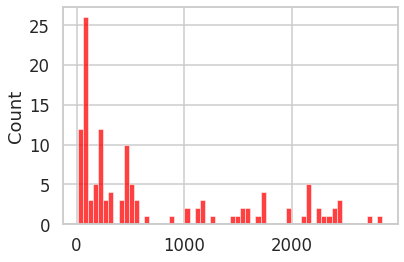

In [87]:
%matplotlib inline
drug_feature_list = []
drug_neighbor_map = {}
selected_drug_list = []
missing_drug_gene = {}
missing_genes = []

for drug, target_list in drug_target_map.items():
    drug_neighbor_map[drug] = set()

    for gene in target_list:

        if gene not in gene_exp_neighbor_map and gene not in gene_neighbor_map:
            # add to the missing drug-gene pair list for further investigation
            if drug in missing_drug_gene:
                missing_drug_gene[drug].append(gene)
            else:
                missing_drug_gene[drug] = [gene]

        if gene in gene_exp_neighbor_map:
            # concatenate the sets
            drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_exp_neighbor_map[gene]

        if gene in gene_neighbor_map:
            drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_neighbor_map[gene]
            # gene_neighbor_map - find potential targets (correlated genes)

    if len(drug_neighbor_map[drug]) != 0:
        selected_drug_list.append(drug)
        drug_feature_list.append(len(drug_neighbor_map[drug])) # number of associated gene per drug

sns.set_style("whitegrid")
sns.set_context("talk")
# sns.distplot(drug_feature_list,color='r',bins=60,kde=False,norm_hist=False)
sns.histplot(drug_feature_list,color='r',bins=60,kde=False)

In [88]:
# selected drug list: which one has the actual gene target

In [89]:
# discrepancy between drugs in paper and priority drugs

In [90]:
#drugs = pd.read_csv(drug_cell_line_file,index_col=1)[["drug","ic50"]].fillna(0)

# drugs = drugs[drugs["drug"].isin(drug2id_mapping.keys())]
# drugs["DRUG_ID"] = [drug2id_mapping[i] for i in drugs["drug"].tolist()]
# drugs = drugs[["DRUG_ID","drug","ic50"]]
# drugs.columns = ["DRUG_ID","Drug","iC50"]
# drugs["LNIC50"] = np.log(drugs["iC50"])
# #drugs = drugs.drop(["DATASET_VERSION","IC50_RESULTS_ID","MAX_CONC_MICROMOLAR","RMSE"],axis=1)
# drugs_cell_line_list = list(drugs.index.unique())
# # print len(drugs_cell_line_list)
# # drug_list = drugs["DRUG_ID"]
# # new_drug_id = []

# PDTC_drugs = pd.read_csv(PDTC_drug_cell_line_file,sep='\t',index_col=0)[["Drug","iC50"]]
# PDTC_drugs_cell_line_list = list(PDTC_drugs.index.unique())
# # print len(drugs_cell_line_list)
# drug_list = PDTC_drugs["Drug"].tolist()
# new_drug_id = []
# for i in drug_list:
#     if i in drug2id_mapping.keys():
#         new_drug_id.append(drug2id_mapping[i])
#     else:
#         new_drug_id.append(0)
# PDTC_drugs["DRUG_ID"] = new_drug_id
# PDTC_drugs= PDTC_drugs[["DRUG_ID","Drug","iC50"]]
# PDTC_drugs["LNIC50"] = np.log(PDTC_drugs["iC50"])
# #PDTC_drugs = PDTC_drugs.drop(["Drug","iC50","D1_CONC","D5_CONC","perc.iC50"],axis=1)

# drugs = pd.concat([drugs,PDTC_drugs])

# drugs_cell_line_list = list(drugs.index.unique())
drugs = pd.read_csv(drug_cell_line_file,index_col=0)
drugs.index = drugs["cell"].tolist()
#drugs = drugs.drop(["DATASET_VERSION","IC50_RESULTS_ID","MAX_CONC_MICROMOLAR","RMSE"],axis=1)
drugs_cell_line_list = list(drugs.index.unique())
drugs["LN_IC50"] = np.log(drugs["ic50"])
# print len(drugs_cell_line_list)
drug_list = drugs["drug"]
drugs = drugs[["drug","LN_IC50"]]
drugs.columns = ["Drug","LN_IC50"]
reference_drug_list = drugs["Drug"].tolist()
new_drug_id = []

drugs_cell_line_list = list(drugs.index.unique())
PDTC_drugs = pd.read_csv(PDTC_drug_cell_line_file,sep='\t',index_col=0)
PDTC_drugs_cell_line_list = list(PDTC_drugs.index.unique())
# print len(drugs_cell_line_list)
drug_list = PDTC_drugs["Drug"].tolist()
new_drug_id = []
# for i in drug_list:
#     if i in drug2id_mapping.keys():
#         new_drug_id.append(drug2id_mapping[i])
#     else:
#         new_drug_id.append(0)
#PDTC_drugs["DRUG_ID"] = new_drug_id
PDTC_drugs["LN_IC50"] = np.log(PDTC_drugs["iC50"])
PDTC_drugs = PDTC_drugs[["Drug","LN_IC50"]]
PDTC_drug_list = PDTC_drugs["Drug"].tolist()
total_drug_list = list(set(reference_drug_list) & set(PDTC_drug_list))
#PDTC_drugs = PDTC_drugs.drop(["Drug","iC50","D1_CONC","D5_CONC","perc.iC50"],axis=1)

drugs = pd.concat([drugs,PDTC_drugs])
drugs = drugs[drugs["Drug"].isin(total_drug_list)]
drugs_cell_line_list = list(drugs.index.unique())
# cell lines that have response to drugs

## find a giant cell line list across GDSC + PDTC

In [91]:
cell_line_list = list(set(drugs_cell_line_list)&set(exp_cell_line_list)&set(mutation_cell_line_list))

cell_line_legend = pd.read_csv(cell_line_detail_file, index_col=1)[["site"]]
cell_line_legend.columns = ['Site']

#cell_line_legend.columns = ["Site"]
#PDTC_cell_line = pd.DataFrame({'Line': ["BRCA"]*len(PDTC_exfp_cell_line_list), 'Site':["PDTC"]*len(PDTC_exp_cell_line_list),"Histology":["breast"]*len(PDTC_exp_cell_line_list)},index=PDTC_exp_cell_line_list)
PDTC_cell_line = pd.DataFrame({'Site':["PDTC"]*len(PDTC_exp_cell_line_list)},index=PDTC_exp_cell_line_list)

cell_line_legend = pd.concat([cell_line_legend,PDTC_cell_line])


In [92]:
cell_line_list = list(set(cell_line_legend.index.tolist()) & set(cell_line_list)) 

In [93]:
cell_line_legend["Site"] = [i.replace(" ", "_") for i in cell_line_legend["Site"].tolist()]

In [94]:
cell_line_legend["Site"] = [i.split("/")[0] for i in cell_line_legend["Site"].tolist()]

In [95]:
# identify the tissue the cell belong to
tissue_map = {}

for cell_line in cell_line_list:
    
    tissue = cell_line_legend.loc[cell_line,'Site']
    
    if tissue not in tissue_map:
        tissue_map[tissue] = []
        
    tissue_map[tissue].append(cell_line)

large_tissue_number = 0
for tissue, cell_line in tissue_map.items():
    
    if len(cell_line) >= 15:
        large_tissue_number += 1
    
    print (tissue, len(cell_line))
    # # of cell lines each tissue correspond to

print('How many tissues', len(tissue_map))
print('Large tissues', large_tissue_number)


Bladder 20
Lung 120
Esophagus 52
Skin 38
Bowel 41
CNS 34
Breast 39
Ovary 34
Pancreas 31
Soft_Tissue 10
Peripheral_Nervous_System 12
Myeloid 33
Lymphoid 83
Liver 19
Bone 11
Ampulla_of_Vater 2
Uterus 27
Thyroid 10
Head_and_Neck 31
PDTC 19
Kidney 20
Pleura 8
Biliary_Tract 4
Prostate 5
How many tissues 24
Large tissues 16


In [96]:
# filter mutation / genes that are under-expressed 

In [97]:
new_exp_gene_list = []
for i in exp_gene_list:
    if i in valid_gene_list:
        new_exp_gene_list.append(i)

exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]

new_data_file = ''

exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]

common_genes = list(set(new_exp_df.columns.tolist()) & set(new_mutation_df.columns.tolist()))
new_exp_df= new_exp_df[common_genes]
new_mutation_df = new_mutation_df[common_genes]
filtered_exp_gene_list = common_genes
filtered_mut_gene_list = common_genes

common_cells = list(set(new_exp_df.index.tolist()) & set(new_mutation_df.index.tolist()))
new_exp_df= new_exp_df.loc[~new_exp_df.index.duplicated(keep='last'),:].copy()
new_mutation_df = new_mutation_df.loc[~new_mutation_df.index.duplicated(keep='last'),:].copy()

In [98]:
drugs = drugs.drop_duplicates()

In [99]:
dataset = "CTRP_PDTC"

In [100]:
# for each drug in the selected drug list, if there is mappable target, see cell-line response
rename_selected_drug_list = []

for drug in selected_drug_list:
    #print(drug)
    
    if drug not in drug2id_mapping:
        print('drug name wrong', drug)
        # drugs that do not have mappable targets - thus no features
        
    else:
        cell_line_drug_matrix = drugs[drugs["Drug"] == drug]
        
        # find gene targets that are significantly expressed
        feature_exp_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_exp_gene_list) )
        feature_mut_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_mut_gene_list) )
        #print(len(feature_exp_gene_list) + len(feature_mut_gene_list))
        if len(feature_exp_gene_list) + len(feature_mut_gene_list) == 0:
            continue
        feature_description = []

        drug_tissue_map = {}
        
        # reformat drug names
        drug = drug.replace(' ','_')

        rename_selected_drug_list.append(drug)

        # print drug
        if drug == 'Nutlin-3a_(-)':
            drug = 'Nutlin-3a'
        
        # make folder to hold drug features
 

        # print 'Generate features', drug
        
        # iterate through every tissue, make a feature profile for each tissue (instead of cell line)
        for tissue, tissue_cell_line_list in tissue_map.items():
            # find every cell line in tissue with drug response
            drug_specific_cell_line = set( cell_line_drug_matrix.index ) & set( tissue_cell_line_list )
            if len(drug_specific_cell_line) > 1:
                drug_folder = f"/data/drug_features/{dataset}/drug_feature/" + drug + '/'
                if not os.path.exists(drug_folder):
                    os.makedirs(drug_folder)
                drug_specific_cell_line = list(drug_specific_cell_line)
                
                # key: tissue; map to cell lines with response
                drug_tissue_map[tissue] = drug_specific_cell_line

                feature_list = []

                # find the response of cell lines that corresponds to the target
                if len(feature_exp_gene_list) != 0:
                    feature_list.append(new_exp_df.loc[ drug_specific_cell_line, feature_exp_gene_list ].values)
                    for gene in feature_exp_gene_list:
                        feature_description.append(gene+'_expression')

                # same as above, expresssion with the corresponding drug targets
                if len(feature_mut_gene_list) != 0:
                    feature_list.append(new_mutation_df.loc[ drug_specific_cell_line, feature_mut_gene_list ].values )
                    for gene in feature_mut_gene_list:
                        feature_description.append(gene+'_mutation')

                # concatenate
                feature = np.concatenate(feature_list, axis=1)

                # assign drug response
                label = cell_line_drug_matrix.loc[ drug_specific_cell_line,'LN_IC50'].values

                #label = new_crispr_df.loc[ tissue_cell_line_list, label_gene ].values

                # print feature.shape, label.shape
                # write all drugs feature / label at once (so merge GDSC/PDTC)
                np.save(drug_folder + tissue + '_' + drug + '_feature.npy', feature )
                np.save(drug_folder + tissue + '_' + drug + '_label.npy', label)
                # mutation / expression - genes that are added
                np.save(drug_folder + tissue + '_feature_description.npy', np.asarray(feature_description))
        # save drug tissue map (cell-lines of interest for tissue for drug)
        if len(drug_tissue_map.keys()) < 10:
            os.system(f"rm -R /data/drug_features/{dataset}/drug_feature/{drug}")
        else:
            file_handle = open(f"/data/drug_features/{dataset}/" + drug+'_tissue_cell_line_list.pkl',"wb")
            pickle.dump(drug_tissue_map,file_handle)
            file_handle.close()
    
# drugs we have access t

drug name wrong VX-680
drug name wrong HG-6-64-1
drug name wrong BAY 61-3606
drug name wrong I-BET 151
drug name wrong XL-880
drug name wrong Nutlin-3a
drug name wrong PLX4720 (rescreen)
drug name wrong Afatinib (rescreen)
